# Install Dependencies

In [53]:
!python -m pip install beautifulsoup4 yfinance

  Using cached yfinance-0.1.74-py2.py3-none-any.whl (27 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)


# Import Dependencies

In [79]:
from bs4 import BeautifulSoup
import requests
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt

# Config

In [44]:
symbol = 'AAPL'

# Implementation

In [45]:
def get_html_page(url: str) -> object:
    response: requests.Response = requests.get(url=url, headers={
        'Cache-Control': 'no-cache',
        'User-Agent': 'PostmanRuntime/7.29.0',
        'Accept': '*/*',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive'
    })
    response_text: str = response.text

    return BeautifulSoup(response_text, 'html.parser')

In [46]:
class ValuationResult(object):
    def __init__(self,
                 current_price: float,
                 valuation_price: float):
        self.current_price = current_price
        self.valuation_price = valuation_price
        self.absolute_current_v_valuation_delta = 1 - (min(valuation_price, current_price) / max(valuation_price, current_price))
        self.is_overvalued = valuation_price < current_price

In [47]:
def determine_intrinsic_value_for_symbol(symbol: str) -> ValuationResult:
    symbol_summary_url = f'https://finviz.com/quote.ashx?t={symbol}'
    symbol_summary_html = get_html_page(url=symbol_summary_url)

    eps_ttm: float = float(symbol_summary_html.find(text='EPS (ttm)').find_next(class_='snapshot-td2').text)
    eps_five_years: float = float(symbol_summary_html.find(text='EPS next 5Y').find_next(class_='snapshot-td2').text.replace('%', '')) / 100
    pe_ratio: float = float(symbol_summary_html.find(text='P/E').find_next(class_='snapshot-td2').text)
    forward_pe_ratio: float = float(symbol_summary_html.find(text='Forward P/E').find_next(class_='snapshot-td2').text)
    avg_pe_ratio: float = (pe_ratio + forward_pe_ratio) / 2
    current_price: float = float(symbol_summary_html.find(text='Price').find_next(class_='snapshot-td2').text)
    
    print(f'EPS: {eps_ttm}, EPS Next 5 Years: {eps_five_years}%, P/E Ratio: {avg_pe_ratio}, Current Price: $ {current_price}')
    
    intrinsic_value: float = determine_intrinsic_value(eps_ttm=eps_ttm,
                          growth_rate=eps_five_years,
                          pe_ratio=avg_pe_ratio,
                          margin_of_safety=0.3)

    print(f'Intrinsic Value: $ {intrinsic_value} vs. Current Price: $ {current_price}')

    return ValuationResult(
        current_price=current_price,
        valuation_price=intrinsic_value,
    )

In [48]:
def determine_intrinsic_value(eps_ttm: float, # Total trailing annual earnings per share.
                              growth_rate: float, # Projected 5 year EPS.
                              pe_ratio: float, # Price per earnings growth rate. 2x growth_rate if unsure.
                              min_rate_of_return: float = 0.15, # Rate of return we want to make.
                              margin_of_safety: float = 0.3 # Margin to padd our valuation with in order to mitigate risk. 20-50% usually.
                              ) -> float:
    assert eps_ttm > 1
    assert growth_rate > 0 and growth_rate < 1
    assert pe_ratio > 1
    assert min_rate_of_return > 0 and min_rate_of_return < 1
    assert margin_of_safety > 0 and margin_of_safety < 1
    
    target_ten_year_eps: float = eps_ttm

    for year in range(2, 11):
        target_ten_year_eps *= (1 + growth_rate)

    target_ten_year_share_price: float = target_ten_year_eps * pe_ratio
    target_share_price: float = target_ten_year_share_price

    for year in range(2, 11):
        target_share_price /= (1 + growth_rate)

    return target_share_price / (1 + margin_of_safety)

# Usage

In [56]:
valuation = determine_intrinsic_value_for_symbol(symbol=symbol)

vars(valuation)

EPS: 6.05, EPS Next 5 Years: 0.0983%, P/E Ratio: 25.835, Current Price: $ 161.51
Intrinsic Value: $ 120.23211538461538 vs. Current Price: $ 161.51


{'current_price': 161.51,
 'valuation_price': 120.23211538461538,
 'absolute_current_v_valuation_delta': 0.2555747917490224,
 'is_overvalued': True}

# Visualization

In [57]:
ticker = yf.Ticker(symbol)
hist = ticker.history(period="max")

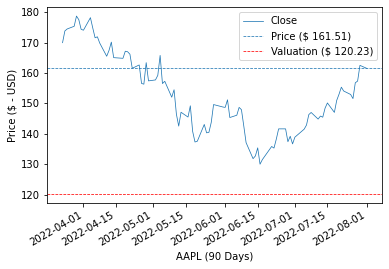

In [111]:
with plt.rc_context({'lines.linewidth': 0.75}):
    view_last_x_days = 90
    data_to_visualize = hist[-view_last_x_days:].Close
    plot = data_to_visualize.plot()
    plot.set_xlabel(f'{symbol} ({view_last_x_days} Days)')
    plot.set_ylabel('Price ($ - USD)')
    current_price_line = plot.axhline(valuation.current_price, linestyle='--', label=f'Price ($ {round(valuation.current_price, 2)})')
    current_valuation_line = plot.axhline(valuation.valuation_price, color=('r' if valuation.is_overvalued else 'g'), linestyle='--', label=f'Valuation ($ {round(valuation.valuation_price, 2)})')
    plot.legend()